In [1]:
import numpy as np
import os
import pathlib
import sys

if pathlib.Path(os.getcwd()).parents[2] not in sys.path:
    sys.path.append(str(pathlib.Path(os.getcwd()).parents[2]))

from Sensors.BatEcho.Spatializer import Render
from Sensors.BatEcho import Setting as sensorconfig
from Gym.BeaconDocking_v0 import Helper
from Arena import Builder

np.random.seed(1)

In [3]:
from Control.SensorimotorLoops.BatEcho import AvoidApproach, Avoid
from Simulation.Motion import State
from Control.SensorimotorLoops import Setting as controlconfig

from matplotlib import pyplot as plt
%matplotlib inline

### Create Maze, Beacons and Bat Pose

In [ ]:
obstacles = Helper.box_builder('')
bat_pose, beacons = Helper.initializer(jit=1)
# merge obstacles and beacons into an objects array
objects = Helper.concatenate_beacons(beacon_objs=Helper.beacons2objects(beacons), 
                                     objects=obstacles)

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=100)
ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=20)
ax.scatter(bat_pose[0], bat_pose[1], s=10)
ax.quiver(bat_pose[0], bat_pose[1], np.cos(bat_pose[2]), np.sin(bat_pose[2]))

ax.set_aspect('equal')

In [ ]:
pose = np.copy(bat_pose)
render = Render()
state = State(pose=pose, dt=1/40)
controller = AvoidApproach()
poses = np.copy(pose).reshape(1,3)
for _ in range(5000):
    compressed = render.run(pose, objects)
    if Helper.collision_check(render.cache['inview'], 'plant'):
        print('HIT PLANT')
        break
    if Helper.collision_check(render.cache['inview'], 'pole'):
        print('HIT POLE')
        break
    v, omega = controller.get_kinematic(compressed)
    state.update_kinematic(kinematic=[v, omega])
    state.update_pose()
    pose = state.pose
    poses = np.vstack((poses, pose.reshape(1,3)))



In [ ]:
quiverspacing=100
fig, ax = plt.subplots(dpi=100)
ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=100)
ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=20)
ax.plot(poses[:,0], poses[:,1], linewidth=1, alpha=0.5)
ax.scatter(poses[np.where(actions==1)][:,0],poses[np.where(actions==1)][:,1], c='r', s=10, alpha=0.5)

ax.quiver(poses[::quiverspacing,0], poses[::quiverspacing,1], np.cos(poses[::quiverspacing,2]), np.sin(poses[::quiverspacing,2]), scale=15, width=5e-3, alpha=0.5)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
ax.set_aspect('equal')

### Luck Policy
1. If see the bay --> Approach
2. Else --> Avoid

Seeing is defined as:
    1. seeing the beacons inview:
    2. the beacon yaw and bat yaw are opposite

-> Need write 3 functions for this

In [ ]:
#bat_inview_spec = [np.pi/4, 2]
#beacon_inview_spec = [np.pi/3, 2]
#epsilon=0.5
pose = np.copy(bat_pose)
render = Render()
state = State(pose=pose, dt=1/40)
controller = AvoidApproach()
poses = np.copy(pose).reshape(1,3)
actions = []
for _ in range(50000):
    compressed = render.run(pose, objects)
    docked, cache = Helper.docking_check_with_beacons(pose, beacons)
    if docked:
        print('DOCKED')
        break
    if Helper.collision_check(render.cache['inview'], 'plant'):
        print('HIT PLANT')
        break
    if Helper.collision_check(render.cache['inview'], 'pole'):
        print('HIT POLE')
        break
    beacon_in_range, _ =Helper.docking_check_with_beacons(pose, beacons, range=1.5, angle=np.pi/4)
    action = 1 if beacon_in_range else 0
    actions.append(action)
    v, omega = controller.get_kinematic(compressed,approach_factor=action)
    state.update_kinematic(kinematic=[v, omega])
    state.update_pose()
    pose = state.pose
    poses = np.vstack((poses, pose.reshape(1,3)))

actions = np.asarray(actions)

In [ ]:
quiverspacing=50
fig, ax = plt.subplots(dpi=100)
ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=100)
ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=20)
ax.plot(poses[:,0], poses[:,1], linewidth=1, alpha=0.5)
ax.scatter(poses[np.where(actions==1)][:,0],poses[np.where(actions==1)][:,1], c='r', s=10, alpha=0.5)

ax.quiver(poses[::quiverspacing,0], poses[::quiverspacing,1], np.cos(poses[::quiverspacing,2]), np.sin(poses[::quiverspacing,2]), scale=15, width=5e-3, alpha=0.5)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
ax.set_aspect('equal')

## Test different locomotion mode here with a single beacon

In [ ]:
class NewController(Avoid):
    def __init__(self, background=None, **kwargs):
        super().__init__(background)
        self.steer_damper = controlconfig.APPROACH_STEER_DAMPING
        self.approach_factor = 0 if 'approach_factor' not in kwargs.keys() else kwargs['approach_factor']
        self.tracked_IID = 0 if 'tracked_IID' not in kwargs.keys() else kwargs['tracked_IID']


    def get_kinematic(self, input_echoes, approach_factor=None, tracked_IID=None):
        if approach_factor is not None: self.approach_factor = approach_factor
        if tracked_IID is not None: self.tracked_IID = tracked_IID
        cues = self.get_cues(input_echoes)
        v = self._get_linear_velocity(cues)
        omega = self._get_angular_velocity(cues, v=v)
        self.kine_cache.update({'v': v, 'omega': omega})
        return v, omega


    def _get_angular_velocity(self, cues,v=None):
        iid = cues['IID']
        if v is None:
            v = self._get_linear_velocity(cues)
        turning_radius = self._calc_turning_radius(iid, v, cues['onset_distance'])
        omega = self._calc_angular_velocity(v, turning_radius)
        if np.abs(omega) > self.max_angular_velocity:
            omega = np.sign(omega)*self.max_angular_velocity
        return self._angular_accel_cap(omega)
    

    def _calc_angular_velocity(self, v, R):
        if R!=0: return v/R
        else: return controlconfig.MAX_ANGULAR_VELOCITY

    
    def _calc_turning_radius(self, iid, v, onset_distance):
        R_min = np.power(v,2) / self.centri_accel
        A = self.approach_factor
        scaled_IID = (iid - self.tracked_IID) / (self.steer_damper - np.sign(iid - self.tracked_IID)*self.tracked_IID)
        scaled_IID = np.sign(iid - self.tracked_IID) if np.abs(scaled_IID)>1 else scaled_IID
        approach_term = -np.sign(iid - self.tracked_IID)*(np.log(np.abs(scaled_IID))-R_min) if scaled_IID!= 0 else sys.float_info.max
        scaled_onset = (onset_distance)/np.max(sensorconfig.COMPRESSED_DISTANCE_ENCODING)
        scaled_onset = 1 if scaled_onset>1 else scaled_onset
        avoid_term = -np.sign(iid)*(R_min - np.log(1-scaled_onset)) if scaled_onset<1 else sys.float_info.max
        if onset_distance < self.B*self.body_radius:
            avoid_term = np.sign(self.kine_cache['omega'])*np.abs(avoid_term)
        #self.cache['approach_term'] = approach_term
        #self.cache['avoid_term'] = avoid_term
        
        return A*approach_term + (1-A)*avoid_term

In [8]:
beacons = np.asarray([0,2,-np.pi/2], dtype=np.float32).reshape(1,3)
bat_pose = np.asarray([0,0, np.pi/2], dtype=np.float32).reshape(3,)
objects = Helper.beacons2objects(beacons=beacons)
def outbound(pose, limit=6.):
    if (np.sum(np.power(pose[:2],2))>limit**2): return True
    else: return False


In [9]:
beacons = np.asarray([0,0,-np.pi/2], dtype=np.float32).reshape(1,3)

objects = Helper.beacons2objects(beacons=beacons)
xls = np.arange(-1.4,1.5,0.1)
yls = np.arange(0,-1.5,-0.1)
als = np.asarray([5,6,7,8,9,10,11,12,13],dtype=np.float32)*(np.pi/18)
docked_list = []
undocked_list=[]
for a in als:
    for y in yls:
        for x in xls:
            pose = np.asarray([x,y,a], dtype=np.float32)
            if Helper.dockingCheck(pose,beacons): docked_list.append(pose) #, beacon_range=0.8, beacon_fov=np.pi/3, facing_fov=6*np.pi/18
            else: undocked_list.append(pose)

docked_list = np.asarray(docked_list).reshape(-1,3)
undocked_list = np.asarray(undocked_list).reshape(-1,3)

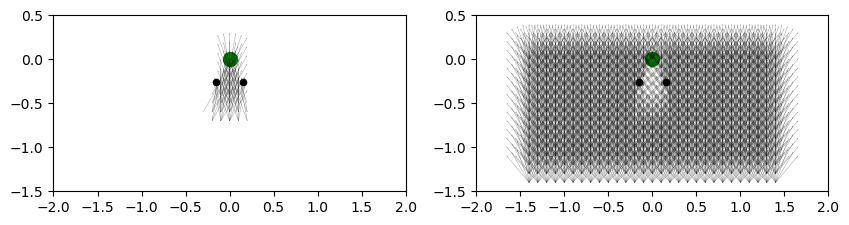

In [10]:
fig, ax = plt.subplots(1,2, dpi=100, figsize=(10,5))
ax[0].scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=100)
ax[0].scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=20)
ax[1].scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=100)
ax[1].scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=20)
ax[0].set_xlim([-2,2])
ax[0].set_ylim([-1.5,0.5])
ax[0].set_aspect('equal')
ax[1].set_xlim([-2,2])
ax[1].set_ylim([-1.5,0.5])
ax[1].set_aspect('equal')

ax[0].quiver(docked_list[:,0], docked_list[:,1], 
            np.cos(docked_list[:,2]), np.sin(docked_list[:,2]), 
            scale=10, width=1e-3, alpha=0.5)
ax[1].quiver(undocked_list[:,0], undocked_list[:,1], 
            np.cos(undocked_list[:,2]), np.sin(undocked_list[:,2]), 
            scale=10, width=1e-3, alpha=0.5)

In [24]:
import time
def evaluate_approach_space():
    xls = np.arange(-5.,5.1,0.1)
    yls = np.arange(-0.5,-8.1,-.1)
    als = np.arange(0.,21., 1.)*(np.pi/18)
    poses = []
    scores = []
    success = False
    for i,a in enumerate(als):
        tic = time.time()
        for j,y in enumerate(yls):
            for k,x in enumerate(xls):
                tic = time.time()
                init_pose = np.asarray([x,y,a], dtype=np.float32)
                poses.append(init_pose)
                score = 0
                for _ in range(20):
                    outcome = run_one_approach_episode(init_pose, objects, outbound, time_limit=500)
                    score += 1 if outcome=='docked' else 0
                score /= 20
                #print('idx=[{0},{1},{2}]'.format(i,j,k),'pose='+str(np.round(init_pose,2)), 'score{0}'.format(score), 'elapse={0}s'.format(np.round(time.time()-tic,2)))
                scores.append(score)
        toc = time.time()
        tictoc = int((toc-tic)/60)
        print('Progress={0}/{1} | Time={2}h{3}m'.format(i+1,len(als), int(tictoc/60),int(tictoc%60)))

    return np.asarray(scores), np.asarray(poses)


def run_one_approach_episode(init_pose, objects, outbound_function, time_limit=1000):
    controller = AvoidApproach(approach_factor=1)
    render = Render()
    pose = np.copy(init_pose)
    state = State(pose=pose, dt=1/40)
    for _ in range(time_limit):
        compressed = render.run(pose, objects)
        docked = Helper.dockingCheck(pose, beacons)
        if docked: return 'docked'
        if Helper.collision_check(render.cache['inview'], 'plant'): return 'hit'
        if Helper.collision_check(render.cache['inview'], 'pole'): return 'hit'
        if outbound_function(pose): return 'out'
        v, omega = controller.get_kinematic(compressed, approach_factor=1)
        state.update_kinematic(kinematic=[v, omega])
        state.update_pose()
        pose = state.pose
    return 'out'


In [25]:
scores_matrix, poses_matrix = evaluate_approach_space()

In [ ]:
np.savez('data.npz', scores = scores_matrix, poses=poses_matrix)

In [14]:
!git add data.npz
!git commit -m "update data"
!git push


[main 2fede5f] update data
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 16 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 886 bytes | 886.00 KiB/s, done.
Total 6 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/huythinhnguyen/2wheel_lite_sim.git
   e20df31..2fede5f  main -> main


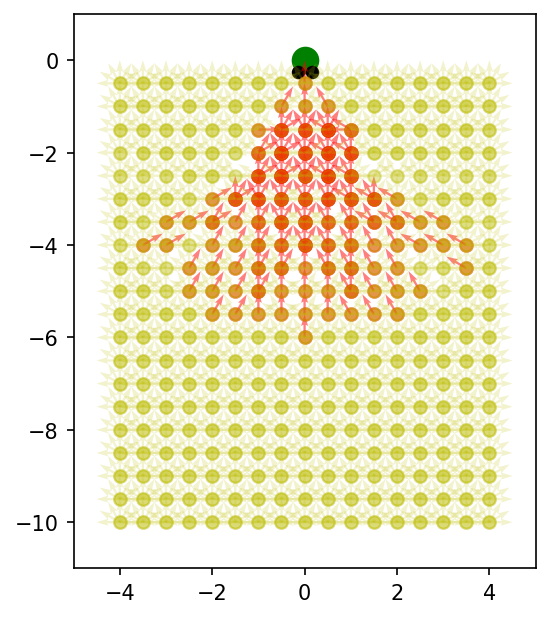

In [23]:
fig, ax = plt.subplots(dpi=150)
ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=150)
ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=30)
#ax.scatter(poses_matrix[scores_matrix==1.0][:,0], poses_matrix[scores_matrix==1.0][:,1], c='r', s=10, alpha=0.5)
#ax.scatter(poses_matrix[scores_matrix==0.][:,0], poses_matrix[scores_matrix==0.][:,1], c='y', s=10, alpha=0.2)
#ax.scatter(poses[np.where(actions==1)][:,0],poses[np.where(actions==1)][:,1], c='r', s=10, alpha=0.5)
cond = scores_matrix==1.
ax.scatter(poses_matrix[cond][:,0],poses_matrix[cond][:,1], c='r', alpha=0.5)
ax.quiver(poses_matrix[cond][:,0],poses_matrix[cond][:,1], np.cos(poses_matrix[cond][:,2]), np.sin(poses_matrix[cond][:,2]),
          scale=20, width=5e-3, color='r', alpha=0.5)
cond = scores_matrix==0.
ax.scatter(poses_matrix[cond][:,0],poses_matrix[cond][:,1], c='y', alpha=0.1)
ax.quiver(poses_matrix[cond][:,0],poses_matrix[cond][:,1], np.cos(poses_matrix[cond][:,2]), np.sin(poses_matrix[cond][:,2]),
          scale=20, width=5e-3, color='y', alpha=0.2)
#ax.quiver(poses[::quiverspacing,0], poses[::quiverspacing,1], np.cos(poses[::quiverspacing,2]), np.sin(poses[::quiverspacing,2]), scale=15, width=5e-3, alpha=0.5)
ax.set_xlim([-5,5])
ax.set_ylim([-11,1])
ax.set_aspect('equal')

In [ ]:
pose = np.asarray([0, -1, np.pi/2]).reshape(3,)
controller = AvoidApproach(approach_factor=1)
render = Render()
state = State(pose=pose, dt=1/40)
poses = []
for _ in range(200):
    compressed = render.run(pose, objects)
    docked = Helper.dockingCheck(pose, beacons)
    if docked:
        print('DOCKED')
        break
    if Helper.collision_check(render.cache['inview'], 'plant'): 
        print('hit plant')
        break
    if Helper.collision_check(render.cache['inview'], 'pole'):
        print('hit pole')
        break
    if outbound(pose):
        print('out')
        break
    v, omega = controller.get_kinematic(compressed, approach_factor=1)
    state.update_kinematic(kinematic=[v, omega])
    state.update_pose()
    pose = state.pose
    poses.append(pose)
poses = np.asarray(poses)

In [ ]:
quiverspacing=50
fig, ax = plt.subplots(dpi=100)
ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=100)
ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=20)
ax.plot(poses[:,0], poses[:,1], linewidth=1, alpha=0.5)
#ax.scatter(poses[np.where(actions==1)][:,0],poses[np.where(actions==1)][:,1], c='r', s=10, alpha=0.5)

ax.quiver(poses[::quiverspacing,0], poses[::quiverspacing,1], np.cos(poses[::quiverspacing,2]), np.sin(poses[::quiverspacing,2]), scale=15, width=5e-3, alpha=0.5)
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
ax.set_aspect('equal')

In [ ]:
pose = np.copy(bat_pose)
render = Render()
#state = State(pose=pose, dt=1/40)
#controller = NewController(tracked_IID=0.)
poses = np.copy(pose).reshape(1,3)
actions = []
iids = []
vs=[]
omegas=[]
for x in range(1000):
    compressed = render.run(pose, objects)
    docked = Helper.dockingCheck(pose, beacons)
    if docked:
        print('DOCKED')
        break
    if Helper.collision_check(render.cache['inview'], 'plant'):
        print('HIT PLANT')
        break
    if Helper.collision_check(render.cache['inview'], 'pole'):
        print('HIT POLE')
        break
    if outbound(pose):
        print('OUT')
        break
    action = 1
    actions.append(action)
    v, omega = controller.get_kinematic(compressed, approach_factor=action)
    vs.append(v)
    omegas.append(omega)
    iids.append(controller.cache['IID'])
    state.update_kinematic(kinematic=[v, omega])
    state.update_pose()
    pose = state.pose
    poses = np.vstack((poses, pose.reshape(1,3)))

actions = np.asarray(actions)

In [ ]:
quiverspacing=50
fig, ax = plt.subplots(dpi=100)
ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=100)
ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=20)
ax.plot(poses[:,0], poses[:,1], linewidth=1, alpha=0.5)
#ax.scatter(poses[np.where(actions==1)][:,0],poses[np.where(actions==1)][:,1], c='r', s=10, alpha=0.5)

ax.quiver(poses[::quiverspacing,0], poses[::quiverspacing,1], np.cos(poses[::quiverspacing,2]), np.sin(poses[::quiverspacing,2]), scale=15, width=5e-3, alpha=0.5)
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
ax.set_aspect('equal')

In [ ]:
plt.plot(iids, alpha=0.8, label='IID')
plt.plot(omegas, alpha=0.8, label='oemgas')
plt.legend()
